# Rotating MRIs

C:\Users\mayap\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


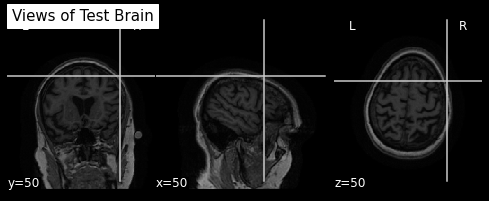

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from nipy.algorithms.registration.scripting import aff2rot_zooms
from nipy.algorithms.registration.scripting import aff2euler
img = nib.load(r"C:\Users\mayap\BSI Internship\005_S_1341_F-73.nii")
arr = img.get_fdata()
top_slic = arr[100,:,:]
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
plot_anat(img,(50,50,50),title="Views of Test Brain")

**Part One:** Successfully Rotating In First Use Case

(1.5710581860927035, -1.4139783373838275, -1.5707961076284864)

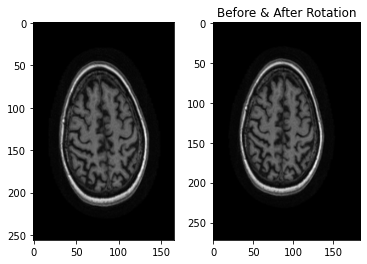

In [12]:
# imports
from nibabel.affines import from_matvec
from nibabel.affines import to_matvec
from nibabel.affines import apply_affine
from nilearn.image import resample_img
from nibabel.eulerangles import mat2euler
import pandas as pd

# sub-alignment functions, each given one value
def x_rotate(orig_arr,x_rot):
    arr = np.array([[1,0,0],
                      [0,np.cos(x_rot),-np.sin(x_rot)],
                      [0,np.sin(x_rot),np.cos(x_rot)]])
    arr = from_matvec(arr)
    return arr.dot(orig_arr)

def y_rotate(orig_arr,y_rot):
    arr = np.array([[np.cos(y_rot),0,np.sin(y_rot)],
                      [0,1,0],
                      [-np.sin(y_rot),0,np.cos(y_rot)]])
    arr = from_matvec(arr)
    return arr.dot(orig_arr)

def z_rotate(orig_arr,z_rot):
    arr = np.array([[np.cos(z_rot),-np.sin(z_rot),0],
                      [np.sin(z_rot),np.cos(z_rot),0],
                      [0,0,1]])
    arr = from_matvec(arr)
    return arr.dot(orig_arr)

# condense into one function
def rotate_mri(img,x_rot,y_rot,z_rot,slice_num,title="Before & After Rotation"):
    # get original array, affine, & sample
    arr_data = img.get_fdata()
    ref_affine = img.affine
    sample_slice = arr_data[slice_num,:,:]
    # modify the affine
    new_affine = x_rotate(ref_affine,x_rot)
    new_affine = y_rotate(new_affine,y_rot)
    new_affine = z_rotate(new_affine,z_rot)
    mat, vec = to_matvec(new_affine)
    r, z = aff2rot_zooms(new_affine)
    angles = aff2euler(r)
    # print out the Euler angles
    # create new image with resample
    rotated = resample_img(img,new_affine)
    arr_data_2 = rotated.get_fdata()
    # visualize the difference
    sample_slice_2 = arr_data_2[slice_num,:,:]
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample_slice,cmap="gray")
    ax[1].imshow(sample_slice_2,cmap="gray")
    plt.title(f"{title}")
    # TODO - should write a CSV with Euler angle values as columns, number as rows, number, print a "number"
    return rotated, angles

# test
new_image, angles = rotate_mri(img,0,0,-math.pi/20,100)
angles

In [8]:
nib.eulerangles.euler2mat(1.5710582417978771, -1.4139783373838273, -1.5707961076284849)

array([[-4.09048469e-05, -1.56176032e-01, -9.87729237e-01],
       [-2.58481937e-04, -9.87729203e-01,  1.56176038e-01],
       [-9.99999966e-01,  2.61698523e-04,  3.42285418e-08]])

In [164]:
# Save to view in ITK - Snap
folder_path = r"C:\Users\mayap\BSI Internship"
new_fpath = os.path.join(folder_path,"rotated2.nii")
nib.save(new_image,new_fpath)

**Part Two:** Value Search

In [20]:
# list of values to search - within two full radians
def search(axis,step_size=math.pi/20):
    search_values = np.arange(-math.pi,math.pi+0.1,step_size)
    x_search = search_values
    y_search = search_values
    z_search = search_values
    x_list = []
    y_list = []
    z_list = []
    if axis.lower() == "z":
        for num in range(len(search_values)):
            image, angles = rotate_mri(img,0,0,search_values[num],100,f"Z-Rotation with Angle Set {num}")
            x_list.append(angles[0])
            y_list.append(angles[1])
            z_list.append(angles[2])
    elif axis.lower() == "y":
        for num in range(len(search_values)):
            image, angles = rotate_mri(img,0,search_values[num],0,100,f"Y-Rotation with Angle Set {num}")
            x_list.append(angles[0])
            y_list.append(angles[1])
            z_list.append(angles[2])
    elif axis.lower() == "y":
        for num in range(len(search_values)):
            image, angles = rotate_mri(img,0,search_values[num],0,100,f"Y-Rotation with Angle Set {num}")
            x_list.append(angles[0])
            y_list.append(angles[1])
            z_list.append(angles[2])
    df = pd.DataFrame({"X-Angle":x_list,"Y-Angle":y_list,"Z-Angle":z_list})
    df.to_csv('eulerangles.csv')
    return df

<ipython-input-12-ba7c4d8d1dd0>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


,X-Angle,Y-Angle,Z-Angle
0,1.570927,1.570535,-1.570666
1,1.571058,1.413455,-1.570796
2,1.571058,1.256375,-1.570796
3,1.571058,1.099296,-1.570796
4,1.571058,0.942216,-1.570796
5,1.571058,0.785137,-1.570796
6,1.571058,0.628057,-1.570796
7,1.571058,0.470977,-1.570796
8,1.571058,0.313898,-1.570796
9,1.571058,0.156818,-1.570796


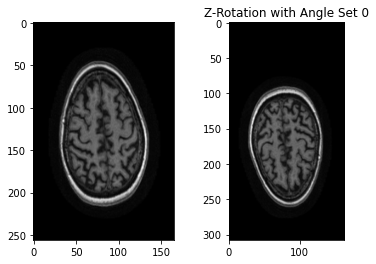

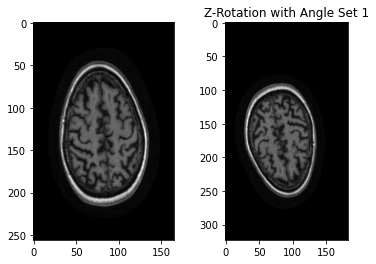

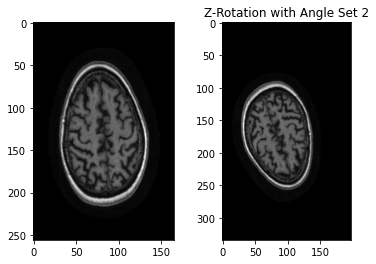

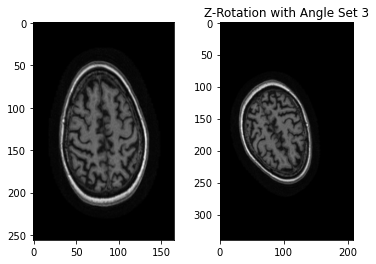

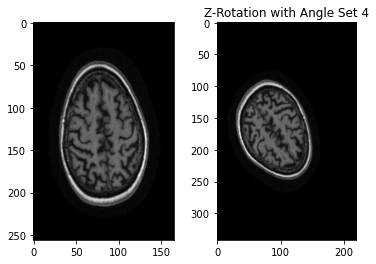

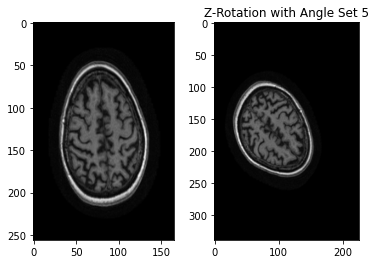

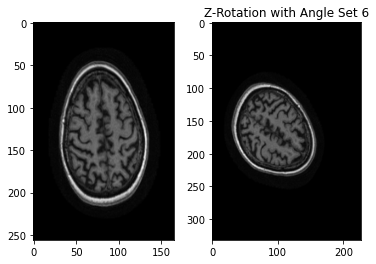

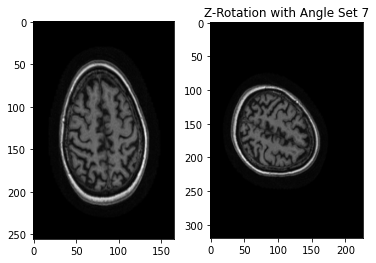

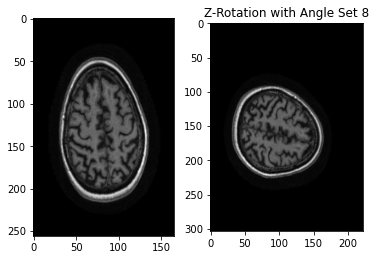

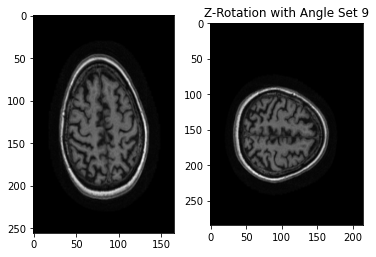

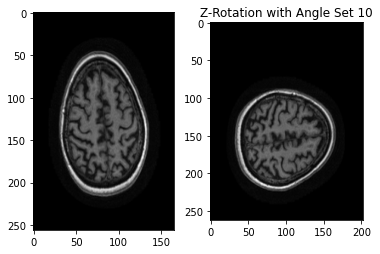

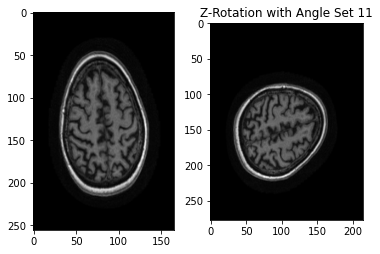

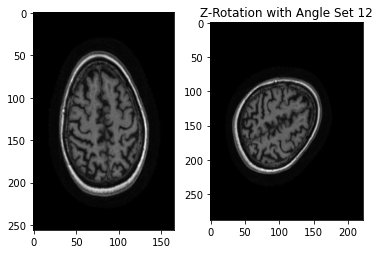

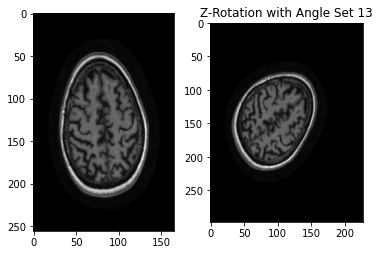

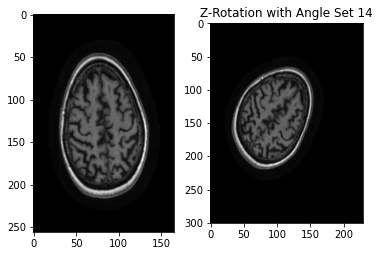

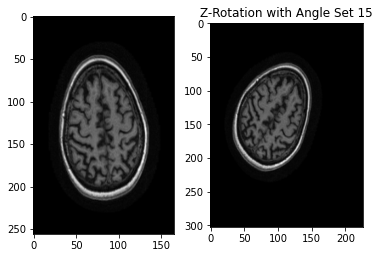

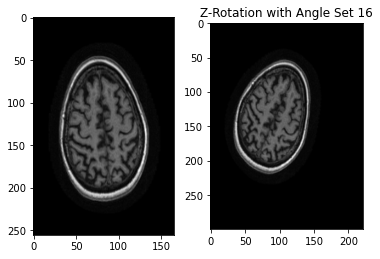

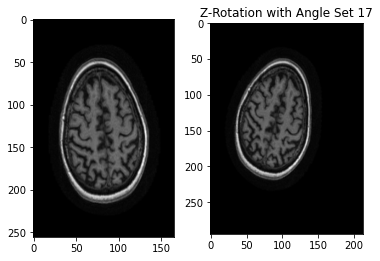

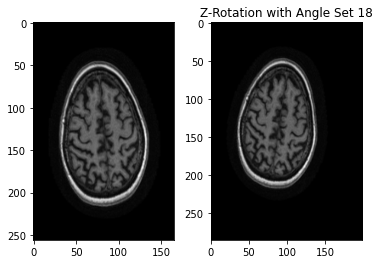

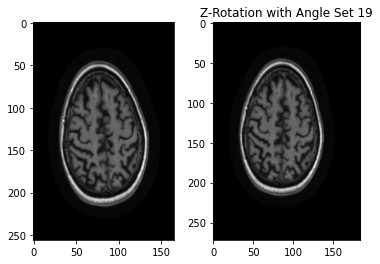

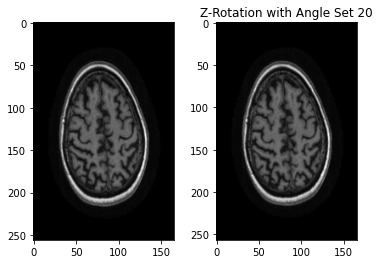

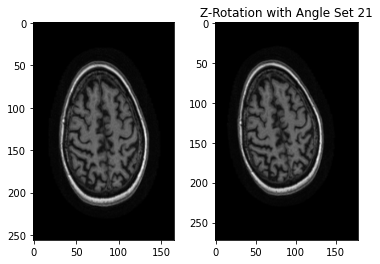

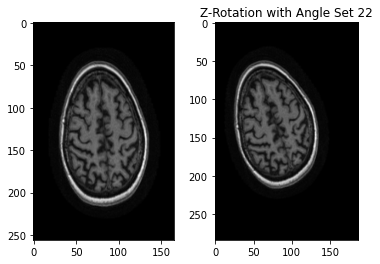

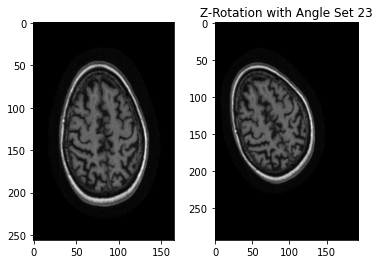

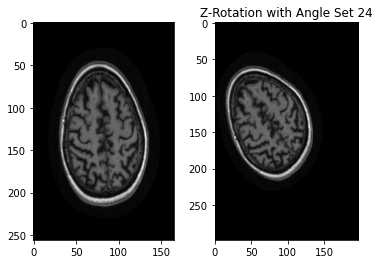

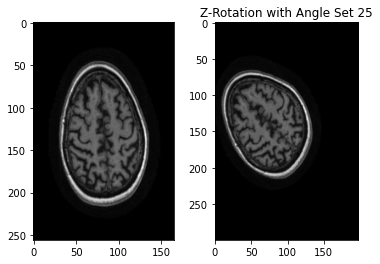

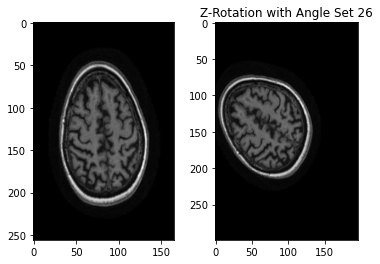

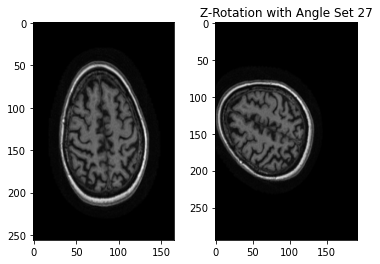

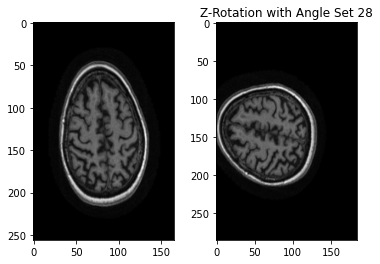

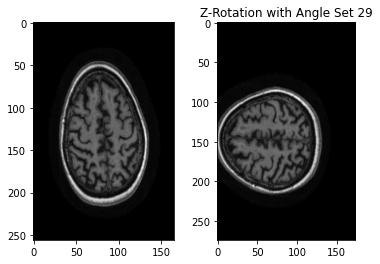

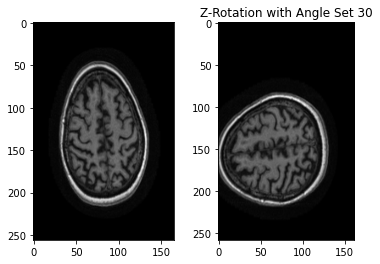

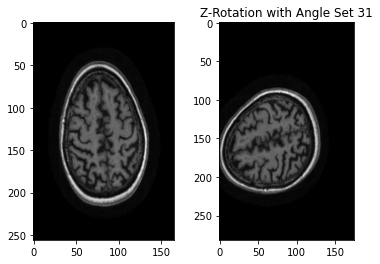

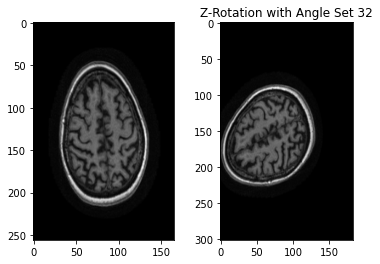

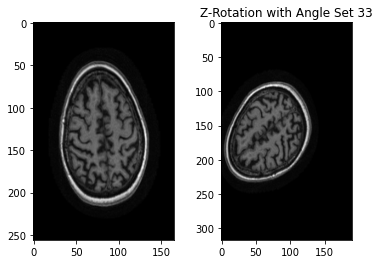

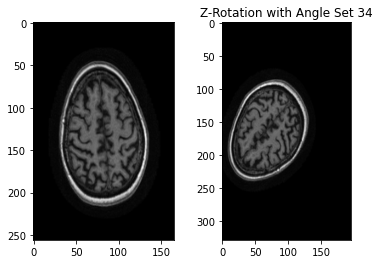

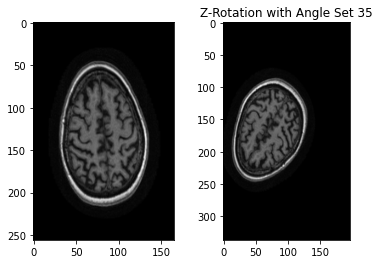

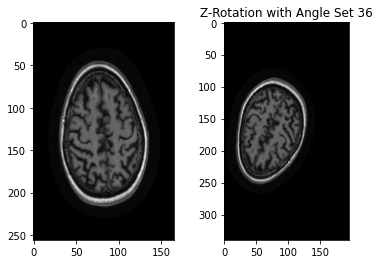

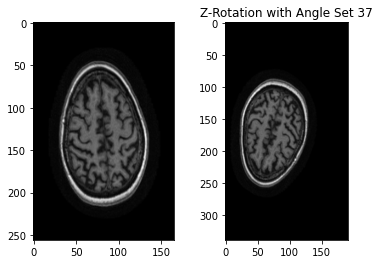

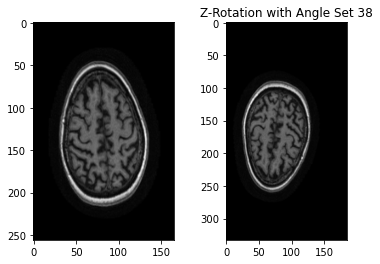

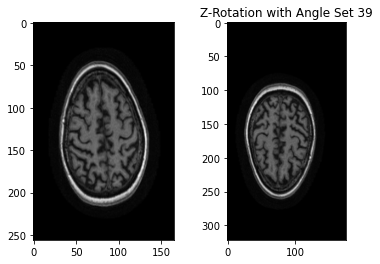

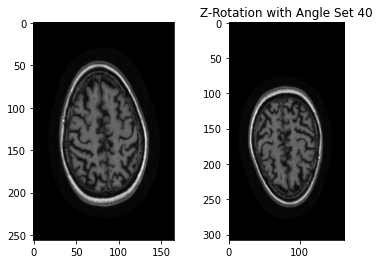

In [21]:
search("z")

In [7]:
import numpy as np
import math
search_values = np.arange(-math.pi,math.pi+0.1,math.pi/30)
len(search_values)

61

selection function - gives option to save new nift file and also gives triplet

**Next Steps:**
* YT vids on ITK-Snap
* Printing Euler's with the comparative slices
* Save a CSV with Euler's and rows
* Interactive display, Plotly